In [92]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import os
from torch.utils.data import TensorDataset, DataLoader
import cv2 as cv
torch.cuda.is_available()

False

In [93]:
class ConvNet(nn.Module):
    def __init__(self):
         super(ConvNet, self).__init__()
         self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=8),
            nn.ReLU(), nn.MaxPool2d(kernel_size=8))
         self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=4),
            nn.ReLU(), nn.MaxPool2d(kernel_size=4))
         self.drop_out = nn.Dropout()
         self.fc1 = nn.Linear(576, 256)
         self.fc2 = nn.Linear(256, 9)

    def forward(self, x): 
      out = self.layer1(x) 
      out = self.layer2(out) 
      out = out.reshape(out.size(0), -1) 
      out = self.drop_out(out) 
      out = self.fc1(out) 
      out = self.fc2(out) 
      return out
      


In [94]:
num_epochs = 5
num_classes = 9
batch_size = 120
learning_rate = 0.001
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [95]:
directory = ".\\cropped\\"
image_files = list(map(lambda x: directory + x, os.listdir(directory)))

In [96]:
def prepare_image(image):
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return (cv.resize(img, (128, 128)) / 255)

In [97]:
target_colors = [
    'black',
    'blue',
    'green',
    'grey',
    'orange',
    'red',
    'silver',
    'white',
    'yellow',
]
len(target_colors)

9

In [98]:
x_data = []
y_data = []
for color in target_colors:
    print(color)
    for image in os.listdir(f'archive/train/{color}'):
        x_data.append(prepare_image(f'archive/train/{color}/{image}'))
        y_data.append(target_colors.index(color))

black
blue
green
grey
orange
red
silver
white
yellow


In [99]:
tensor_x = torch.Tensor(x_data)
tensor_y = torch.Tensor(y_data).type(torch.LongTensor)

In [100]:
my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

In [107]:
total_step = len(dataloader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        # Прямой запуск
        images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [10/38], Loss: 0.3552, Accuracy: 87.50%
Epoch [1/5], Step [20/38], Loss: 0.2995, Accuracy: 88.33%
Epoch [1/5], Step [30/38], Loss: 0.4871, Accuracy: 80.83%
Epoch [2/5], Step [10/38], Loss: 0.4848, Accuracy: 84.17%
Epoch [2/5], Step [20/38], Loss: 0.3982, Accuracy: 85.00%
Epoch [2/5], Step [30/38], Loss: 0.3629, Accuracy: 87.50%
Epoch [3/5], Step [10/38], Loss: 0.3127, Accuracy: 89.17%
Epoch [3/5], Step [20/38], Loss: 0.4051, Accuracy: 85.00%
Epoch [3/5], Step [30/38], Loss: 0.3109, Accuracy: 89.17%
Epoch [4/5], Step [10/38], Loss: 0.3900, Accuracy: 85.83%
Epoch [4/5], Step [20/38], Loss: 0.2714, Accuracy: 90.00%
Epoch [4/5], Step [30/38], Loss: 0.2051, Accuracy: 92.50%
Epoch [5/5], Step [10/38], Loss: 0.4007, Accuracy: 85.00%
Epoch [5/5], Step [20/38], Loss: 0.2085, Accuracy: 95.00%
Epoch [5/5], Step [30/38], Loss: 0.3613, Accuracy: 85.00%


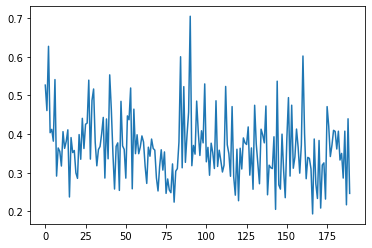

In [108]:
plt.plot(loss_list)

In [106]:
torch.save(model, '.\\model_v3.pt')

In [ ]:
image_files = list(map(lambda x: 'cropped\\' + x, os.listdir('cropped')))

Predicted Color = red


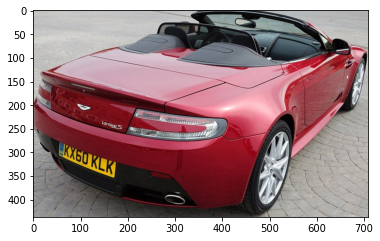

In [80]:
from random import choice
img = choice(image_files)
with torch.no_grad():
    logps = model(torch.Tensor([prepare_image(img)]).permute(0, 3, 1, 2))

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
plt.imshow(cv.cvtColor(cv.imread(img), cv.COLOR_BGR2RGB))
print("Predicted Color =", target_colors[probab.index(max(probab))])